### Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
import sys, os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chi2
pd.set_option('display.max_columns', None)
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# location of the scripts
sys.path.insert(0, os.getcwd() + "/../scripts/")
import geometry as geom

### Paths and directories

In [2]:
# Root path of this script
root = os.getcwd() + "/"
# Path to store objects
root_objects = root + f"objects/"

# Some filenames -------------------
# Filename of the total table
fname_runwise_table  = root_objects + "runwise_total_dict.pkl"

####################################
# --- POWER LAW PARAMETERS REF --- #
ref_p0 =  1.74 
ref_p1 = -2.23
####################################

# Create the paths that do not exist
for path in [root + "plots/"]:
    if not os.path.exists(path):
        os.makedirs(os.path.join(path), exist_ok=True)

### Reading the run-wise table

In [3]:
# Read DataFrame from CSV
df_runwise = pd.read_csv(fname_runwise_table)
df_runwise.set_index("run", inplace=True)

display(df_runwise[:6])

,n_subruns,telapsed,timestamp,az,zd,i_half_peak,drdi,u_drdi,pindex,u_pindex,light_yield,u_light_yield,pressure,temperature,humidity,wind_speed,tng_dust,tng_seeing,fit_slope,fit_u_slope,fit_intercept,fit_u_intercept,fit_chi2,fit_pvalue
run,,,,,,,,,,,,,,,,,,,,,,,,
1615,61,1479.185384,2019-11-23 23:40:47.731307,265.754848,31.359290,124.759916,2.045992,0.020157,-2.126104,0.059882,1.155216,0.013513,787.011475,7.588689,45.536721,14.341311,0.380000,1.710000,-0.000016,0.000006,1.158636,0.005587,259.529051,0.000000
1616,62,1492.465697,2019-11-24 00:11:26.987927,95.332874,30.722616,124.538413,2.085128,0.021588,-2.114527,0.062913,1.176689,0.015404,786.889839,7.951452,46.629677,14.384194,0.277419,2.077581,0.000009,0.000004,1.169722,0.003368,69.341068,0.191536
1617,35,877.161720,2019-11-24 00:45:42.507987,273.215706,44.511343,118.418470,2.049730,0.019581,-2.127638,0.058021,1.157435,0.013404,786.620000,7.710571,51.568000,15.432286,0.260000,2.140000,0.000004,0.000007,1.150611,0.003916,71.571138,0.000114
1618,81,1822.499924,2019-11-24 01:07:29.246502,108.322078,18.014448,125.807134,2.164965,0.038297,-2.051108,0.094747,1.160424,0.066008,786.379877,7.585802,60.808272,13.873580,0.086790,2.463827,0.000001,0.000004,1.182540,0.003499,252.113457,0.000000
1619,30,922.360651,2019-11-24 01:45:25.986127,279.314177,57.571760,112.330784,2.045831,0.021450,-2.085522,0.063585,1.161393,0.015284,786.082000,7.658333,58.738667,15.738000,0.030000,2.570000,-0.000030,0.000009,1.174208,0.005152,42.331114,0.040341
1620,78,1748.229183,2019-11-24 02:03:06.030581,148.833255,8.163757,125.248930,2.099011,0.021409,-2.123014,0.061951,1.182556,0.015357,785.949103,7.733974,57.757564,16.961667,0.030000,2.375385,-0.000024,0.000003,1.199698,0.003803,124.860485,0.000352


## Creating another dataframes

In [4]:
df_max_pval = df_runwise.nlargest(100, 'fit_pvalue')
df_min_pval = df_runwise.nsmallest(100, 'fit_pvalue')

runs_performance_paper = [ 2914, 2929, 2930, 2931, 2932, 2933, 2934, 2949, 2950, 2967, 2968,
                           2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2988, 2989,
                           2990, 2991, 2992, 3004, 3005, 3006, 3007, 3008, 3093, 3094, 3095,
                           3096, 3231, 3232, 3243, 3270, 3271, 3272, 3273, 3274, 3275, 3276,
                           3277, 3278, 3279, 3318, 3319, 3320, 3321, 3328, 3329, 3330, 3338,
                           3339, 3340, 3355, 3356, 3373, 3598, 3599, 3600, 3601, 3615, 3632,
                           3633, 3634, 3635, 3672, 3673, 3674, 3675, 3676, 3677, 3706, 3707,
                           3708, 4067, 4068, 4086, 4087, 6045, 6073, 6304, 6872, 6873, 6874,
                           6875, 6892, 6893, 6894, 6895, 7097, 7098, 7099, 7133, 7136, 7161,
                           7195, 7196, 7197, 7199, 7200, 7227, 7228, 7231, 7232, 7233, 7253,
                           7254, 7255, 7256, 7274, 7275, 7276, 7277]

df_performance = df_runwise.loc[runs_performance_paper]

## Getting the datetime objects of the timestamps

In [5]:
times = np.array([datetime.fromisoformat(t) for t in df_runwise["timestamp"]])
times_performance = np.array([datetime.fromisoformat(t) for t in df_performance["timestamp"]])

times_min_pval = np.array([datetime.fromisoformat(t) for t in df_min_pval["timestamp"]])
times_max_pval = np.array([datetime.fromisoformat(t) for t in df_max_pval["timestamp"]])

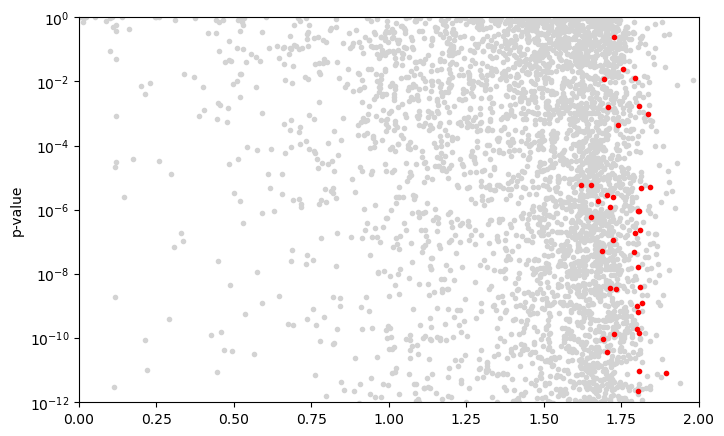

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_runwise["drdi"], df_runwise["fit_pvalue"], marker=".", ls="", color="lightgray")
ax.plot(df_performance["drdi"], df_performance["fit_pvalue"], marker=".", ls="", color="r")

ax.set_xlim(0, 2)
ax.set_ylim(1e-12, 1e0)

ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel("p-value")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

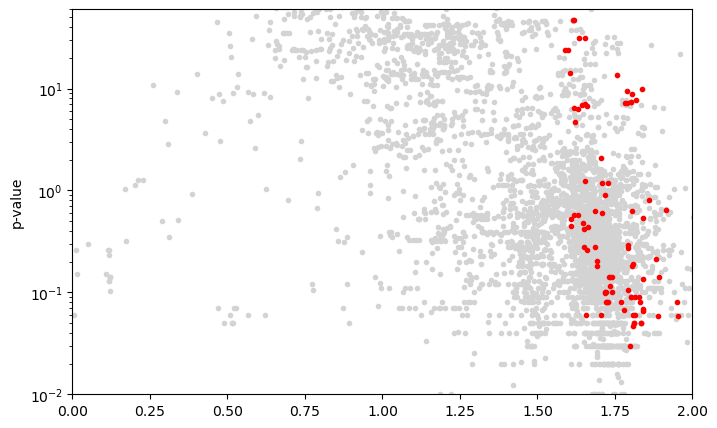

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(df_runwise["drdi"], df_runwise["tng_dust"], marker=".", ls="", color="lightgray")
ax.plot(df_performance["drdi"], df_performance["tng_dust"], marker=".", ls="", color="r")

ax.set_ylim(1e-2, 60)
ax.set_xlim(0, 2)

ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel("p-value")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

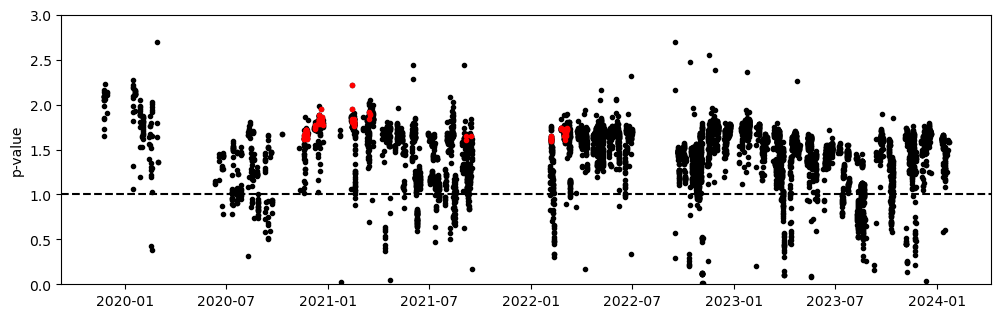

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

ax.plot(times, df_runwise["drdi"], ls="", marker=".", color="k")
ax.plot(times_performance, df_performance["drdi"], ls="", marker=".", color="r")
ax.set_ylim(0, 3)
ax.axhline(1, color="k", ls="--")
ax.set_xlabel("")
ax.set_ylabel("p-value")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

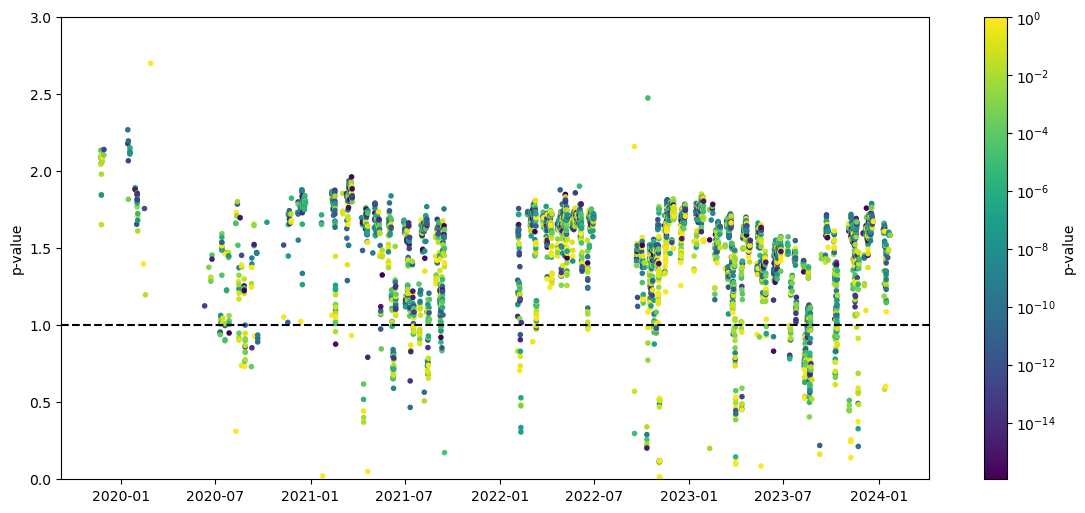

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

sc = ax.scatter(times, df_runwise["drdi"], c=df_runwise["fit_pvalue"], ls="", marker=".",
               norm=mpl.colors.LogNorm())
fig.colorbar(sc, label="p-value")

ax.set_ylim(0, 3)
ax.axhline(1, color="k", ls="--")
ax.set_xlabel("")
ax.set_ylabel("p-value")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))


ax.set_xlabel("")
ax.set_ylabel("# of runs")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))


ax.set_xlabel("")
ax.set_ylabel("# of runs")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))


ax.set_xlabel("")
ax.set_ylabel("# of runs")
ax.set_title("")

# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()